In [1]:
import pandas as pd

df = pd.read_csv('../../data/data.csv')

print(f"Total Rows: {len(df)}")

print(f"Column Names: {df.columns}")

df.head(3)

Total Rows: 188378
Column Names: Index(['conversation_id', 'message', 'sentiment'], dtype='object')


,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpful...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188378 entries, 0 to 188377
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   conversation_id  188378 non-null  int64 
 1   message          188373 non-null  object
 2   sentiment        188378 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.3+ MB


In [3]:
rows_with_nulls = df[df.isnull().any(axis=1)]
print(f"No of nulls messages: {len(rows_with_nulls)}")
rows_with_nulls

No of nulls messages: 5


,conversation_id,message,sentiment
20124,923,NaN,Disgusted
28552,1306,NaN,Happy
31504,1442,NaN,Surprised
83361,3815,NaN,Curious to dive deeper
95303,4361,NaN,Happy


## **Dropping NaN rows below** ##

- NULL messages cannot be classified with sentiment as there is nothing to classify with
- Only 5 rows were dropped, not much loss in data information

In [4]:
df = df.dropna()
df.isnull().sum()

conversation_id    0
message            0
sentiment          0
dtype: int64

## **Sentiments Ground Truth Label Distribution (EDA)** ##

In [5]:
sentiment_counts = df.sentiment.value_counts().reset_index()
sentiment_counts

,sentiment,count
0,Curious to dive deeper,80887
1,Neutral,41367
2,Surprised,30637
3,Happy,29615
4,Sad,2533
5,Disgusted,1432
6,Fearful,1026
7,Angry,876


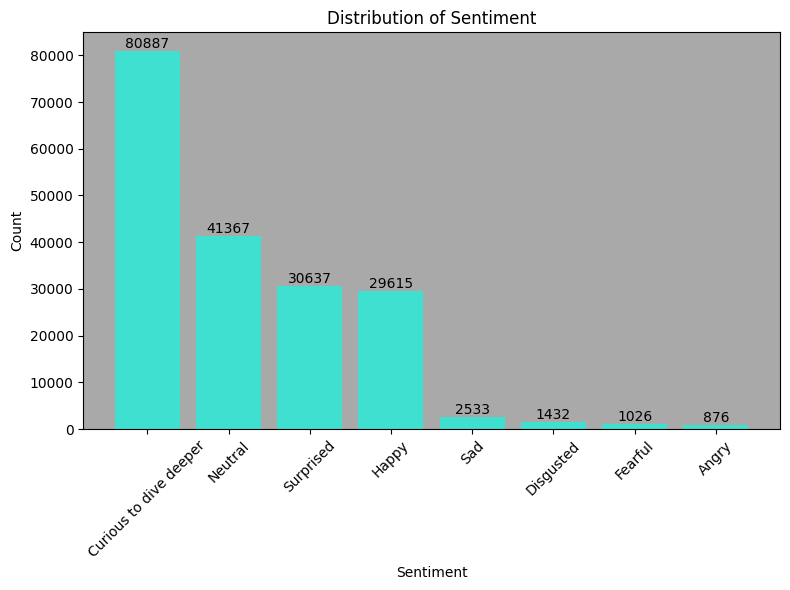

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts['sentiment'], sentiment_counts['count'], color='turquoise')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()

for i, count in enumerate(sentiment_counts['count']):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.gca().set_facecolor('darkgrey')
plt.show()


## **Zero-shot Text Classification: Sentiment-Analysis** ##

### **Model**: <u>facebook/bart-large-mnli</u> ##

Link: https://huggingface.co/facebook/bart-large-mnli

In [7]:
import torch

torch.backends.mps.is_built()

True

In [8]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers.pipelines import Pipeline
from typing import Optional
import torch

def load_model(task: Optional[str]="zero-shot-classification",
               model_name: Optional[str]="facebook/bart-large-mnli") -> Pipeline:
    
    """
        Load model from Hugging Face Transformers library with pretrained
        weights and tokenizer and return a pipeline object.
    """

    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, verbose=False, return_tensors="pt")
    model = AutoModelForSequenceClassification.from_pretrained(model_name, verbose=False)

    print("Running on device: ", device)

    classifier = pipeline(task=task, 
                          model=model, 
                          tokenizer=tokenizer,
                          device=device)
    
    return classifier


/Users/user/anaconda3/envs/splore/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
## Test ## 

message = df.message[1]
ground_truth = df.sentiment[1]
y_labels = df.sentiment.unique().tolist()

classifier = load_model()
res = classifier(message, y_labels, multi_label=False)

print(f"Message: {message}")
print(f"Labels: {y_labels}")

print("\nPrediction:")
print(f"Predicted label: {res['labels'][0]} | Confidence: {res['scores'][0]:.2f}")
print(f"Ground Truth: {ground_truth}")


Running on device:  mps
Message: Both are excellent technology they are helpful in many ways. For the security purpose both are super.
Labels: ['Curious to dive deeper', 'Happy', 'Neutral', 'Surprised', 'Disgusted', 'Sad', 'Fearful', 'Angry']

Prediction:
Predicted label: Surprised | Confidence: 0.23
Ground Truth: Curious to dive deeper


In [10]:
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

savepath = Path("../../data/sentiment-predictions.csv")

def evaluate_and_save_batches(df: pd.DataFrame, classifier: Pipeline, batch_size: int, output_file: Path):

    if not os.path.exists(output_file):
        os.makedirs(output_file.parent, exist_ok=True)

    y_labels = df['sentiment'].unique().tolist()
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = df.iloc[i*batch_size : (i+1)*batch_size]
        y_true_batch = batch['sentiment'].tolist()
        indices_batch = batch.index.tolist()
        y_pred_batch = []

        for message in batch['message']:
            res = classifier(message, y_labels, multi_label=False)
            y_pred_batch.append(res['labels'][0])

        batch_df = pd.DataFrame({'index': indices_batch, 'y_true': y_true_batch, 'y_pred': y_pred_batch})
        
        if i == 0:
            batch_df.to_csv(output_file, index=False, mode='w')
        else:
            batch_df.to_csv(output_file, index=False, mode='a', header=False)
        
        print(f"Processed and saved batch {i+1}/{num_batches}")

def load_and_evaluate(output_file: Path):
    combined_df = pd.read_csv(output_file)
    y_true = combined_df['y_true']
    y_pred = combined_df['y_pred']
    y_labels = y_true.unique().tolist()

    cm = confusion_matrix(y_true, y_pred, labels=y_labels)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_labels, yticklabels=y_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    plt.title('Confusion Matrix')
    plt.show()

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=y_labels))

In [11]:
evaluate_and_save_batches(df, classifier, batch_size=1500, output_file=savepath)

load_and_evaluate(output_file=savepath)

KeyboardInterrupt: 